In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

from torch_geometric.nn import GCNConv

from sklearn import tree, linear_model

import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid
import umap

from torch_geometric.nn import GNNExplainer

from utilities import *
from heuristics import *
from activation_classifier import *
import models

import random
import copy

set_rc_params()

# ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
# general parameters
dataset_name = "Reddit_Binary"

model_type = Reddit_GCN
load_pretrained = False

# hyperparameters
k = 30

# other parameters
train_test_split = 0.8
num_classes = 4

batch_size = 20
epochs = 1000
lr = 0.005


Dataset: REDDIT-BINARY(2000):
Number of graphs: 2000
Number of features: 1
Number of classes: 2

Data(edge_index=[2, 480], x=[218, 1], y=[1])
Number of nodes: 218
Number of edges: 480
Average node degree: 2.20
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True

Class split - Training 0: 810 1:790, Test 0: 190 1: 210
Epoch: 000, Train Loss: 0.69462, Test Loss: 0.65033, Train Acc: 0.62938, Test Acc: 0.65500
Epoch: 001, Train Loss: 0.62639, Test Loss: 0.74383, Train Acc: 0.53563, Test Acc: 0.50250
Epoch: 002, Train Loss: 0.62829, Test Loss: 0.59210, Train Acc: 0.67000, Test Acc: 0.66750


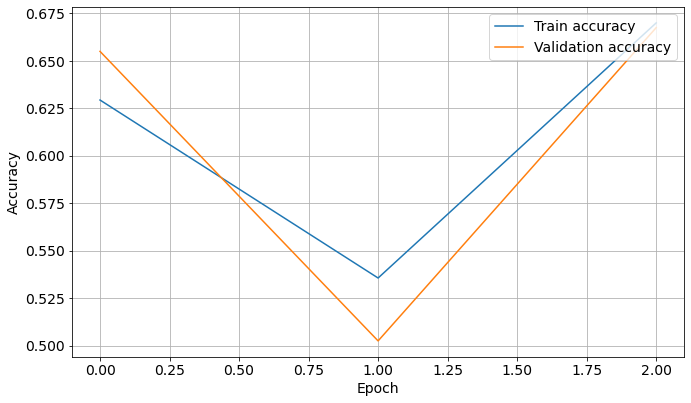

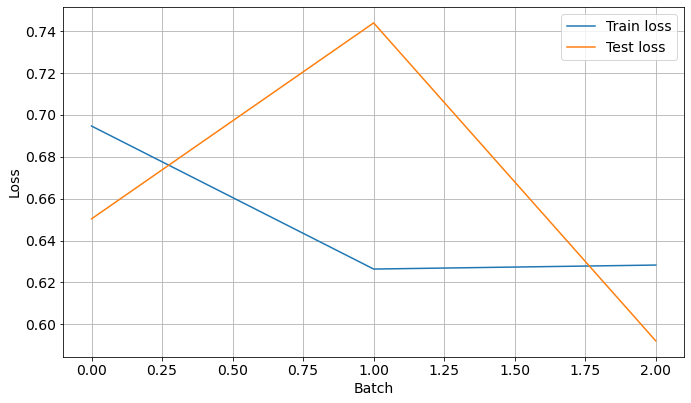

In [3]:
paths = prepare_output_paths(dataset_name + "2", k)

graphs = load_real_data(dataset_name)
train_loader, test_loader, full_loader, small_loader = prepare_real_data(graphs, 0.8, batch_size, dataset_name)
labels = next(iter(full_loader)).y

model = model_type(graphs.num_node_features, graphs.num_classes)

if load_pretrained:
    print("Loading pretrained model...")
    model.load_state_dict(torch.load(os.path.join(paths['base'], "model.pkl")))
    model.eval()
    
    with open(os.path.join(paths['base'], "activations.txt"), 'rb') as file:
        activation_list = pickle.loads(file.read())
        
else:
    model.apply(weights_init)
    train_graph_class(model, train_loader, test_loader, full_loader, 500, lr, paths['base'])

In [ ]:
print(test_graph_class(model, test_loader))
print(test_graph_class(model, train_loader))

In [ ]:
model = register_hooks(model)

# want to get class labels for nodes
full_class_labels = []
full_node_labels = []
full_class_labels_per_node = []

small_class_labels = []
small_node_labels = []
small_class_labels_per_node = []

# do full pass to get data points   
data = next(iter(full_loader))
_ = model(data.x, data.edge_index, data.batch)

test_activation_list = copy.deepcopy(models.activation_list)
full_class_labels = data.y.detach().numpy()
for x, batch_idx in zip(data.x, data.batch):
    full_node_labels.append(np.argmax(x.detach().numpy(), axis=0))
    full_class_labels_per_node.append(data.y[batch_idx])

print("Activation after test ", models.activation_list['conv0'].shape)


# do smaller pass for conv layers
data = next(iter(small_loader))
_ = model(data.x, data.edge_index, data.batch)
small_class_labels = data.y.detach().numpy()

for x, batch_idx in zip(data.x, data.batch):
    small_node_labels.append(np.argmax(x.detach().numpy(), axis=0))
    small_class_labels_per_node.append(data.y[batch_idx])
    
print("Activation after small ", models.activation_list['conv0'].shape)

In [ ]:
# merge activation lists

for key in models.activation_list:
    # skip
    if key.find("lin") != -1:
        continue
    elif key.find("pool") != -1:
        models.activation_list[key] = test_activation_list[key]

# want to get rid of linear layer
models.activation_list.pop("lin")

activation_list = models.activation_list
    
print("Remaining Keys:")
for key in activation_list:
    print(key, " ", activation_list[key].shape)
    


# Dimensionality Reduction

### TSNE

In [ ]:
# TSNE conversion
tsne_models = []
tsne_data = []

print(len(small_node_labels))
print(len(full_class_labels))

for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()

    tsne_model = TSNE(n_components=2)
    d = tsne_model.fit_transform(activation)
    
    if key.find('conv') != -1:        
        plot_activation_space(d, small_node_labels, "t-SNE reduced", layer_num, paths['TSNE'], "(coloured by node labels)", "_nodelabels")
        plot_activation_space(d, small_class_labels_per_node, "t-SNE reduced", layer_num, paths['TSNE'], "(coloured by class labels)", "_classlabels")
    if key.find('pool') != -1:
        plot_activation_space(d, full_class_labels, "t-SNE reduced", layer_num, paths['TSNE'], "(coloured by class labels)")
            
    tsne_models.append(tsne_model)
    tsne_data.append(d)

### PCA

In [ ]:
# PCA conversion
pca_models = []
pca_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pca_model = PCA(n_components=2)
    d = pca_model.fit_transform(activation)
    
    if key.find('conv') != -1:
        plot_activation_space(d, small_node_labels, "PCA reduced", layer_num, paths['PCA'], "(coloured by node labels)", "_nodelabels")
        plot_activation_space(d, small_class_labels_per_node, "PCA reduced", layer_num, paths['PCA'], "(coloured by class labels)", "_classlabels")
    if key.find('pool') != -1:
        plot_activation_space(d, full_class_labels, "PCA reduced", layer_num, paths['PCA'], "(coloured by class labels)")

    pca_models.append(pca_model)
    pca_data.append(d)

### UMAP

In [ ]:
# UMAP conversion
umap_models = []
umap_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    umap_model = umap.UMAP(n_components=2)
    d = umap_model.fit_transform(activation)
    
    if key.find('conv') != -1:
        plot_activation_space(d, small_node_labels, "UMAP reduced", layer_num, paths['UMAP'], "(coloured by node labels)", "_nodelabels")
        plot_activation_space(d, small_class_labels_per_node, "UMAP reduced", layer_num, paths['UMAP'], "(coloured by class labels)", "_classlabels")
    if key.find('pool') != -1:
        plot_activation_space(d, full_class_labels, "UMAP reduced", layer_num, paths['UMAP'], "(coloured by class labels)")

    umap_models.append(umap_model)
    umap_data.append(d)

# Clustering

### KMeans

##### RAW

In [ ]:
num_nodes_view = 5
num_expansions = 2

full_data = next(iter(full_loader))
full_edges = full_data.edge_index.transpose(0, 1).detach().numpy()

small_data = next(iter(small_loader))
small_edges = small_data.edge_index.transpose(0, 1).detach().numpy()

raw_kmeans_sample_feat = []
raw_kmeans_sample_graphs = []
raw_kmeans_models = []

relevant_activations = [(6, 'conv3')]

for layer_num, key in enumerate(activation_list):
    if layer_num == 1:
        k = 4
    else:
        k = 30
    
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(activation)
    pred_labels = kmeans_model.predict(activation)
    
    if key.find('conv') != -1:
        sample_labels = small_class_labels_per_node
        sample_edges = small_edges
        node_labels = small_node_labels
    if key.find('pool') != -1:
        sample_edges = full_edges
        sample_labels = full_class_labels_per_node
        node_labels = full_node_labels
        
#     plot_clusters(tsne_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_TSNE", "(t-SNE reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_PCA", "(PCA reduced)")
#     plot_clusters(umap_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_UMAP", "(UMAP reduced)")
    sample_graphs, sample_feat = plot_samples(kmeans_model, activation, sample_labels, layer_num, k, "Kmeans", "raw", num_nodes_view, sample_edges, num_expansions, paths['KMeans'])

    raw_kmeans_sample_graphs.append(sample_graphs)
    raw_kmeans_sample_feat.append(sample_feat)
    raw_kmeans_models.append(kmeans_model)
    

##### TSNE

In [ ]:
# tsne_kmeans_sample_graphs = []
# tsne_kmeans_sample_feat = []
# tsne_kmeans_models = []

# for layer_num, item in enumerate(tsne_data):
#     kmeans_model = KMeans(n_clusters=k, random_state=0)
#     kmeans_model = kmeans_model.fit(item)
#     pred_labels = kmeans_model.predict(item)

#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#         sample_edges = small_edges
#         node_labels = small_node_labels
#     if key.find('pool') != -1:
#         sample_edges = full_edges
#         sample_labels = full_class_labels_per_node
#         node_labels = full_node_labels
    
#     plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "t-SNE reduced")
#     sample_graphs, sample_feat = plot_samples(kmeans_model, item, sample_labels, layer_num, k, "k-Means", "t-SNE reduced", num_nodes_view, sample_edges, num_expansions, paths['KMeans'], node_labels, "Mutagenicity")

#     tsne_kmeans_sample_graphs.append(sample_graphs)
#     tsne_kmeans_sample_feat.append(sample_feat)
#     tsne_kmeans_models.append(kmeans_model)
    

##### PCA

In [ ]:
# pca_kmeans_sample_graphs = []
# pca_kmeans_sample_feat = []
# pca_kmeans_models = []

# for layer_num, item in enumerate(pca_data):
#     kmeans_model = KMeans(n_clusters=k, random_state=0)
#     kmeans_model = kmeans_model.fit(item)
#     pred_labels = kmeans_model.predict(item)
    
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#         sample_edges = small_edges
#         node_labels = small_node_labels
#     if key.find('pool') != -1:
#         sample_edges = full_edges
#         sample_labels = full_class_labels_per_node
#         node_labels = full_node_labels

#     plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "PCA reduced")
#     sample_graphs, sample_feat = plot_samples(kmeans_model, item, sample_labels, layer_num, k, "k-Means", "PCA reduced", num_nodes_view, sample_edges, num_expansions, paths['KMeans'], node_labels, "Mutagenicity")

#     pca_kmeans_sample_graphs.append(sample_graphs)
#     pca_kmeans_sample_feat.append(sample_feat)
#     pca_kmeans_models.append(kmeans_model)

##### UMAP

In [ ]:
# umap_kmeans_sample_graphs = []
# umap_kmeans_sample_feat = []
# umap_kmeans_models = []
# for layer_num, item in enumerate(umap_data):
#     kmeans_model = KMeans(n_clusters=k, random_state=0)
#     kmeans_model = kmeans_model.fit(item)
#     pred_labels = kmeans_model.predict(item)
    
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#         sample_edges = small_edges
#         node_labels = small_node_labels
#     if key.find('pool') != -1:
#         sample_edges = full_edges
#         sample_labels = full_class_labels_per_node
#         node_labels = full_node_labels

#     plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "UMAP reduced")
#     sample_graphs, sample_feat = plot_samples(kmeans_model, item, sample_labels, layer_num, k, "k-Means", "UMAP reduced", num_nodes_view, sample_edges, num_expansions, paths['KMeans'], node_labels, "Mutagenicity")

#     umap_kmeans_sample_graphs.append(sample_graphs)
#     umap_kmeans_sample_feat.append(sample_feat)
#     umap_kmeans_models.append(kmeans_model)

#### Heuristics

In [ ]:
# ba_heuristics = BA_Shapes_Heuristics()

# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "raw", paths['KMeans'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "t-SNE reduced", paths['KMeans'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "PCA reduced", paths['KMeans'])

# # for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "UMAP reduced", paths['KMeans'])


### Hierarchical Clustering

##### Raw

In [ ]:
# for layer_num, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     plot_dendrogram(activation, "raw", layer_num, paths['Ward'])

In [ ]:
# raw_n_clusters = [30, 30, 30, 30, 30, 30, 30, 5]

# raw_hc_sample_graphs = []
# raw_hc_sample_feat = []
# raw_hc_models = []
# for layer_num, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(activation)
    
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#         sample_edges = small_edges
#         node_labels = small_node_labels
#     if key.find('pool') != -1:
#         sample_edges = full_edges
#         sample_labels = full_class_labels_per_node
#         node_labels = full_node_labels

#     d = (activation, pred_labels)
#     plot_clusters(tsne_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_TSNE", "(t-SNE reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_PCA", "(PCA reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_UMAP", "(UMAP reduced)")
#     sample_graphs, sample_feat = plot_samples(hc, d, sample_labels, layer_num, n, "HC", "raw", num_nodes_view, sample_edges, num_expansions, paths['Ward'], node_labels, "Mutagenicity")

#     raw_hc_sample_graphs.append(sample_graphs)
#     raw_hc_sample_feat.append(sample_feat)
#     raw_hc_models.append(hc)


##### TSNE

In [ ]:
# for layer_num, item in enumerate(tsne_data):
#     plot_dendrogram(item, "t-SNE", layer_num, paths['Ward'])

In [ ]:
# tsne_n_clusters = [7, 30, 15, 30, 30, 30, 12, 3]

# tsne_hc_sample_graphs = []
# tsne_hc_sample_feat = []
# tsne_hc_models = []
# for layer_num, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(item)
    
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#         sample_edges = small_edges
#         node_labels = small_node_labels
#     if key.find('pool') != -1:
#         sample_edges = full_edges
#         sample_labels = full_class_labels_per_node
#         node_labels = full_node_labels

#     d = (item, pred_labels)
#     plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "t-SNE")
#     sample_graphs, sample_feat = plot_samples(hc, d, sample_labels, layer_num, n, "HC", "t-SNE reduced", num_nodes_view, sample_edges, num_expansions, paths['Ward'], node_labels, "Mutagenicity")

#     tsne_hc_sample_graphs.append(sample_graphs)
#     tsne_hc_sample_feat.append(sample_feat)
#     tsne_hc_models.append(hc)


##### PCA

In [ ]:
# for layer_num, item in enumerate(pca_data):
#     plot_dendrogram(item, "PCA", layer_num, paths['Ward'])

In [ ]:
# pca_n_clusters = [30, 30, 10, 2, 30, 30, 30, 4]

# pca_hc_sample_graphs = []
# pca_hc_sample_feat = []
# pca_hc_models = []
# for layer_num, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(item)
    
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#         sample_edges = small_edges
#         node_labels = small_node_labels
#     if key.find('pool') != -1:
#         sample_edges = full_edges
#         sample_labels = full_class_labels_per_node
#         node_labels = full_node_labels

#     d = (item, pred_labels)
#     plot_clusters(item, pred_labels, "HC", n, layer_num, paths['HC'], "PCA")
#     sample_graphs, sample_feat = plot_samples(hc, d, sample_labels, layer_num, n, "HC", "PCA reduced", num_nodes_view, sample_edges, num_expansions, paths['HC'], node_labels, "Mutagenicity")

#     pca_hc_sample_graphs.append(sample_graphs)
#     pca_hc_sample_feat.append(sample_feat)
#     pca_hc_models.append(hc)

##### UMAP

In [ ]:
# for layer_num, item in enumerate(umap_data):
#     plot_dendrogram(item, "UMAP", layer_num, paths['Ward'])

In [ ]:
# umap_n_clusters = [30, 3, 30, 30, 9, 5, 14, 3]

# umap_hc_sample_graphs = []
# umap_hc_sample_feat = []
# umap_hc_models = []
# for layer_num, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(item)
    
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#         sample_edges = small_edges
#         node_labels = small_node_labels
#     if key.find('pool') != -1:
#         sample_edges = full_edges
#         sample_labels = full_class_labels_per_node
#         node_labels = full_node_labels

#     d = (item, pred_labels)
#     plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "UMAP")
#     sample_graphs, sample_feat = plot_samples(hc, d, sample_labels, layer_num, n, "HC", "UMAP reduced", num_nodes_view, sample_edges, num_expansions, paths['Ward'], node_labels, "Mutagenicity")

#     umap_hc_sample_graphs.append(sample_graphs)
#     umap_hc_sample_feat.append(sample_feat)
#     umap_hc_models.append(hc)

#### Heuristics

In [ ]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "raw", paths['Ward'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "t-SNE reduced", paths['Ward'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "PCA reduced", paths['Ward'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "UMAP reduced", paths['Ward'])


### DBSCAN

##### Raw

In [ ]:
# esp = 1
# min_samples = 5

# raw_dbscan_sample_feats = []
# raw_dbscan_sample_graphs = []
# raw_dbscan_models = []
# raw_dbscan_ds = []

# for layer_num, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(activation)
#     pred_labels = dbscan_model.fit_predict(activation)
    
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#         sample_edges = small_edges
#         node_labels = small_node_labels
#     if key.find('pool') != -1:
#         sample_edges = full_edges
#         sample_labels = full_class_labels_per_node
#         node_labels = full_node_labels

#     num_cluster = len(np.unique(pred_labels))
#     d = (activation, pred_labels)
#     raw_dbscan_ds.append(d)

#     plot_clusters(tsne_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_TSNE", "(TSNE Reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_PCA", "(PCA Reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_UMAP", "(UMAP Reduced)")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, sample_labels, layer_num, num_cluster, "DBSCAN", "raw", num_nodes_view, sample_edges, num_expansions, paths['DBSCAN'], node_labels, "Mutagenicity")

#     raw_dbscan_sample_graphs.append(sample_graphs)
#     raw_dbscan_sample_feats.append(sample_feat)
#     raw_dbscan_models.append((dbscan_model, num_cluster))


##### TSNE

In [ ]:
# tsne_dbscan_sample_graphs = []
# tsne_dbscan_sample_feats = []
# tsne_dbscan_models = []
# tsne_dbscan_ds = []

# for layer_num, item in enumerate(tsne_data):
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(item)
#     pred_labels = dbscan_model.fit_predict(item)
    
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#         sample_edges = small_edges
#         node_labels = small_node_labels
#     if key.find('pool') != -1:
#         sample_edges = full_edges
#         sample_labels = full_class_labels_per_node
#         node_labels = full_node_labels

#     num_cluster = len(np.unique(pred_labels))
#     d = (item, pred_labels)
#     tsne_dbscan_ds.append(d)

#     plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "t-SNE")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, sample_labels, layer_num, num_cluster, "DBSCAN", "t-SNE reduced", num_nodes_view, sample_edges, num_expansions, paths['DBSCAN'], node_labels, "Mutagenicity")

#     tsne_dbscan_sample_graphs.append(sample_graphs)
#     tsne_dbscan_sample_feats.append(sample_feat)
#     tsne_dbscan_models.append((dbscan_model, num_cluster))


##### PCA

In [ ]:
# pca_dbscan_sample_graphs = []
# pca_dbscan_sample_feats = []
# pca_dbscan_models = []
# pca_dbscan_ds = []

# for layer_num, item in enumerate(pca_data):
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(item)
#     pred_labels = dbscan_model.fit_predict(item)
    
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#         sample_edges = small_edges
#         node_labels = small_node_labels
#     if key.find('pool') != -1:
#         sample_edges = full_edges
#         sample_labels = full_class_labels_per_node
#         node_labels = full_node_labels

#     num_cluster = len(np.unique(pred_labels))
#     d = (item, pred_labels)
#     pca_dbscan_ds.append(d)

#     plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "PCA")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, sample_labels, layer_num, num_cluster, "DBSCAN", "PCA reduced", num_nodes_view, sample_edges, num_expansions, paths['DBSCAN'], node_labels, "Mutagenicity")

#     pca_dbscan_sample_graphs.append(sample_graphs)
#     pca_dbscan_sample_feats.append(sample_feat)
#     pca_dbscan_models.append((dbscan_model, num_cluster))


##### UMAP

In [ ]:
# umap_dbscan_sample_graphs = []
# umap_dbscan_sample_feats = []
# umap_dbscan_models = []
# umap_dbscan_ds = []

# esp = 0.1
# min_samples = 5

# for layer_num, item in enumerate(umap_data):
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(item)
#     pred_labels = dbscan_model.fit_predict(item)
    
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#         sample_edges = small_edges
#         node_labels = small_node_labels
#     if key.find('pool') != -1:
#         sample_edges = full_edges
#         sample_labels = full_class_labels_per_node
#         node_labels = full_node_labels

#     num_cluster = len(np.unique(pred_labels))
#     d = (item, pred_labels)
#     umap_dbscan_ds.append(d)

#     plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "UMAP")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, sample_labels, layer_num, num_cluster, "DBSCAN", "UMAP reduced", num_nodes_view, sample_edges, num_expansions, paths['DBSCAN'], node_labels, "Mutagenicity")

#     umap_dbscan_sample_graphs.append(sample_graphs)
#     umap_dbscan_sample_feats.append(sample_feat)
#     umap_dbscan_models.append((dbscan_model, num_cluster))



#### Heuristics

In [ ]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "raw", paths['DBSCAN'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "t-SNE reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "PCA reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "UMAP reduced", paths['DBSCAN'])



# Activation to Concept to Class

### Using KMeans

In [ ]:
class ActivationClassifier():
    def __init__(self, pred_data, clustering_model, classifier_type, x, y, train_mask=None, test_mask=None, if_graph_class=False):
        self.pred_data = pred_data
        self.clustering_model = clustering_model
        self.classifier_type = classifier_type

        if if_graph_class:
            self.dataloader = x
            self.y = np.array([int(x.item()) for x in y])
            
            self.train_mask = np.random.rand(len(self.y)) < 0.8
            self.test_mask = ~self.train_mask
        else:
            self.x = x.detach().numpy()
            self.y = y.detach().numpy()
            self.train_mask = train_mask
            self.test_mask = test_mask

        self.if_graph_class = if_graph_class

        if isinstance(self.clustering_model, AgglomerativeClustering) or isinstance(self.clustering_model, DBSCAN):
            self.y_hc = self.clustering_model.fit_predict(self.pred_data)

        self.classifier, self.accuracy = self._train_classifier()


    def _train_classifier(self):
        self.train_concepts = []
        self.test_concepts = []

        for node_idx in range(len(self.train_mask)):
            if self.train_mask[node_idx] == 1:
                self.train_concepts.append([self.activation_to_concept(node_idx)])
            else:
                self.test_concepts.append([self.activation_to_concept(node_idx)])

        if self.classifier_type == 'decision_tree':
            cls = tree.DecisionTreeClassifier()
            cls = cls.fit(self.train_concepts, self.y[self.train_mask])

        elif self.classifier_type == 'logistic_regression':
            cls = linear_model.LogisticRegression()
            print("this ", np.unique(self.y[self.train_mask]))
            cls = cls.fit(self.train_concepts, self.y[self.train_mask])

        # decision tree accuracy
        accuracy = cls.score(self.test_concepts, self.y[self.test_mask])

        return cls, accuracy


    def get_classifier_accuracy(self):
        return self.accuracy


    def _activation_to_cluster(self, node):
        # apply tsne
        if isinstance(self.clustering_model, KMeans):
            cluster = self.clustering_model.predict(self.pred_data)
            cluster = cluster[node]

        elif isinstance(self.clustering_model, AgglomerativeClustering) or isinstance(self.clustering_model, DBSCAN):
            cluster = np.array(self.y_hc[node])

        return cluster


    def _cluster_to_concept(self, cluster):
        concept = cluster

        return concept


    def activation_to_concept(self, node):
        # get cluster for node
        cluster = self._activation_to_cluster(node)

        # return cluster number as substitute of concept
        concept = self._cluster_to_concept(cluster)

        return concept


    def concept_to_class(self, concept):
        concept = concept.reshape(1, -1)
        pred = self.classifier.predict(concept)

        return pred


    def plot(self, path, layer_num, k, reduction_type):
        if self.classifier_type == 'decision_tree':
            fig, ax = plt.subplots(figsize=(20, 20))
            tree.plot_tree(self.classifier, ax=ax)
            fig.suptitle(f"Decision Tree for {reduction_type} Model")

        elif self.classifier_type == 'logistic_regression':
            fig, ax = plt.subplots(figsize=(6, 6))
            pred = self.classifier.predict(self.test_concepts)
            ls = np.unique(self.y)
            confusion_matrix = metrics.confusion_matrix(self.y[self.test_mask], pred, labels=ls)
            cm = pd.DataFrame(confusion_matrix, index=ls, columns=ls)

            ax = sn.heatmap(cm, annot=True, cmap="YlGnBu", ax=ax, fmt='g', )
            fig.suptitle(f"Confusion Matrix of Logistic Regression on for {reduction_type} Model")
            ax.set_xlabel("Target Class")
            ax.set_ylabel("Predicted Class")

        plt.savefig(os.path.join(path, f"{k}k_{layer_num}layer_{reduction_type}_{self.classifier_type}.png"))
        plt.show()

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, key in enumerate(activation_list):
    if key.find('conv') != -1:
        sample_labels = small_class_labels_per_node
    if key.find('pool') != -1:
        sample_labels = full_class_labels
            
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "raw")
    
# for i, item in enumerate(tsne_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
        
#     activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "t-SNE")

# for i, item in enumerate(pca_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "PCA")

# for i, item in enumerate(umap_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "UMAP")

plot_completeness_table("k-Means", "Decision Tree", completeness_scores, paths['KMeans'])

In [ ]:
classifier_str = "logistic_regression"

completeness_scores = []

print(np.unique(small_class_labels_per_node))
print(np.unique(full_class_labels))

for i, key in enumerate(activation_list):
    if key.find('conv') != -1:
        sample_labels = small_class_labels_per_node
    if key.find('pool') != -1:
        sample_labels = full_class_labels
    
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "raw")
    
    
    
# for i, item in enumerate(tsne_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
        
#     activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "t-SNE")

# for i, item in enumerate(pca_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "PCA")

# for i, item in enumerate(umap_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "UMAP")

plot_completeness_table("k-Means", "Logistic Regression", completeness_scores, paths['KMeans'])

### Using Hierarchical Clustering

##### Using Ward

In [ ]:
# classifier_str = "decision_tree"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)
    
#     d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['Ward'], i, k, "raw")
    
# for i, item in enumerate(tsne_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
        
#     activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['Ward'], i, k, "t-SNE")

# for i, item in enumerate(pca_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['Ward'], i, k, "PCA")

# for i, item in enumerate(umap_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     activation_cls = ActivationClassifier(item, umap_hc_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['Ward'], i, k, "UMAP")

# plot_completeness_table("HC", "Decision Tree", completeness_scores, paths['Ward'])


In [ ]:
# classifier_str = "logistic_regression"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)
    
#     d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['Ward'], i, k, "raw")
    
# for i, item in enumerate(tsne_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
        
#     activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['Ward'], i, k, "t-SNE")

# for i, item in enumerate(pca_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['Ward'], i, k, "PCA")

# for i, item in enumerate(umap_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     activation_cls = ActivationClassifier(item, umap_hc_models[i], classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['Ward'], i, k, "UMAP")

# plot_completeness_table("HC", "Logistic Regression", completeness_scores, paths['Ward'])



##### Using DBSCAN

In [ ]:
# classifier_str = "decision_tree"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
    
#     dbscan_model, n = raw_dbscan_models[i]
#     activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, full_loader, sample_labels, if_graph_class=True)
    
#     d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['DBSCAN'], i, n, "raw")
    
# for i, item in enumerate(tsne_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
        
#     dbscan_model, n = tsne_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['DBSCAN'], i, n, "t-SNE")

# for i, item in enumerate(pca_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     dbscan_model, n = pca_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['DBSCAN'], i, n, "PCA")

# for i, item in enumerate(umap_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     dbscan_model, n = umap_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['DBSCAN'], i, n, "UMAP")

# plot_completeness_table("HC", "Decision Tree", completeness_scores, paths['DBSCAN'])


In [ ]:
# classifier_str = "logistic_regression"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
    
#     dbscan_model, n = raw_dbscan_models[i]
#     activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, full_loader, sample_labels, if_graph_class=True)
    
#     d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['DBSCAN'], i, n, "raw")
    
# for i, item in enumerate(tsne_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
        
#     dbscan_model, n = tsne_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['DBSCAN'], i, n, "t-SNE")

# for i, item in enumerate(pca_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     dbscan_model, n = pca_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['DBSCAN'], i, n, "PCA")

# for i, item in enumerate(umap_data):
#     if key.find('conv') != -1:
#         sample_labels = small_class_labels_per_node
#     if key.find('pool') != -1:
#         sample_labels = full_class_labels
    
#     dbscan_model, n = umap_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, full_loader, sample_labels, if_graph_class=True)

#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['DBSCAN'], i, n, "UMAP")

# plot_completeness_table("HC", "Logistic Regression", completeness_scores, paths['DBSCAN'])




# Graph Similarity

In [ ]:
##### KMeans

In [ ]:
graph_scores = []
view = 3
max_num_nodes = 15

relevnat_list = [(6, 'conv3')]

for i, key in relevnat_list:
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    distances = get_node_distances(raw_kmeans_models[i], activation)
    
    if key.find('conv') != -1:
        sample_labels = small_class_labels_per_node
        sample_edges = small_edges
        node_labels = small_node_labels
    if key.find('pool') != -1:
        sample_edges = full_edges
        sample_labels = full_class_labels_per_node
        node_labels = full_node_labels

    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, sample_labels, sample_edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["k-Means", "raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_kmeans_models[i], activation, sample_labels, i, k, "k-Means", "raw", view, sample_edges, num_expansions, paths['KMeans'])
        
        
# for i, item in enumerate(tsne_data):    
#     distances = get_node_distances(tsne_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)

#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["k-Means", "t-SNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(tsne_kmeans_models[i], item, data['y'], i, k, "k-Means", "t-SNE", view, edges, num_expansions, paths['KMeans'])
    
# for i, item in enumerate(pca_data):
#     distances = get_node_distances(pca_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["k-Means", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(pca_kmeans_models[i], item, data['y'], i, k, "k-Means", "PCA", view, edges, num_expansions, paths['KMeans'])


# for i, item in enumerate(umap_data):
#     distances = get_node_distances(umap_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["k-Means", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(umap_kmeans_models[i], item, data['y'], i, k, "k-Means", "UMAP", view, edges, num_expansions, paths['KMeans'])
    
# plot_graph_similarity_table("k-Means", graph_scores, paths['KMeans'])
    

In [ ]:
# graph_scores = []

# for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     pred_labels = raw_hc_models[i].fit_predict(activation)
#     d_item = (activation, pred_labels)
#     distances = get_node_distances(raw_hc_models[i], d_item)
    
#     for k_idx in range(n):        
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
                
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "raw", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(raw_hc_models[i], d_item, data["y"], i, n, "HC", "raw", view, edges, num_expansions, paths['Ward'])
        
        
# for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)): 
#     pred_labels = tsne_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(tsne_hc_models[i], d_item)
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "t-SNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(tsne_hc_models[i], d_item, data["y"], i, n, "HC", "t-SNE", view, edges, num_expansions, paths['Ward'])
        

        
# for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     pred_labels = pca_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(pca_hc_models[i], d_item)

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(pca_hc_models[i], d_item, data["y"], i, n, "HC", "PCA", view, edges, num_expansions, paths['Ward'])
    

# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     pred_labels = umap_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(umap_hc_models[i], d_item)

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(umap_hc_models[i], d_item, data["y"], i, n, "HC", "UMAP", view, edges, num_expansions, paths['Ward'])
        
    
# plot_graph_similarity_table("HC", graph_scores, paths['Ward'])
    

In [ ]:
# graph_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
    
#     dbscan_model, n = raw_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, raw_dbscan_ds[i])

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "raw", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, raw_dbscan_ds[i], data['y'], i, n, "DBSCAN", "raw", view, edges, num_expansions, paths['DBSCAN'])
        
# for i, item in enumerate(tsne_data):  
#     dbscan_model, n = tsne_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, tsne_dbscan_ds[i])
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)

#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "t-SNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, tsne_dbscan_ds[i], data['y'], i, n, "DBSCAN", "t-SNE", view, edges, num_expansions, paths['DBSCAN'])
    
# for i, item in enumerate(pca_data):
#     dbscan_model, n = pca_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, pca_dbscan_ds[i])
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, pca_dbscan_ds[i], data['y'], i, n, "DBSCAN", "PCA", view, edges, num_expansions, paths['DBSCAN'])


# for i, item in enumerate(umap_data):
#     dbscan_model, n = umap_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, umap_dbscan_ds[i])
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, umap_dbscan_ds[i], data['y'], i, n, "DBSCAN", "UMAP", view, edges, num_expansions, paths['DBSCAN'])
    
# plot_graph_similarity_table("DBSCAN", graph_scores, paths['DBSCAN'])
    

# GNNExplainer

In [ ]:
# do smaller pass for conv layers
data = next(iter(small_loader))
_ = model(data.x, data.edge_index, data.batch)
small_class_labels = data.y.detach().numpy()

for x, batch_idx in zip(data.x, data.batch):
    small_node_labels.append(np.argmax(x.detach().numpy(), axis=0))
    small_class_labels_per_node.append(data.y[batch_idx])
    
graph_idx = 0

for i, y_i in enumerate(data.y):
    if y_i == 0:
        graph_idx = i
        print(i)
    


In [ ]:
from copy import copy
from math import sqrt
from typing import Optional

import torch
from tqdm import tqdm
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_networkx


EPS = 1e-15


class GNNExplainer(torch.nn.Module):
    r"""The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s node-predictions.

    .. note::

        For an example of using GNN-Explainer, see `examples/gnn_explainer.py
        <https://github.com/rusty1s/pytorch_geometric/blob/master/examples/
        gnn_explainer.py>`_.

    Args:
        model (torch.nn.Module): The GNN module to explain.
        epochs (int, optional): The number of epochs to train.
            (default: :obj:`100`)
        lr (float, optional): The learning rate to apply.
            (default: :obj:`0.01`)
        num_hops (int, optional): The number of hops the :obj:`model` is
            aggregating information from.
            If set to :obj:`None`, will automatically try to detect this
            information based on the number of
            :class:`~torch_geometric.nn.conv.message_passing.MessagePassing`
            layers inside :obj:`model`. (default: :obj:`None`)
        return_type (str, optional): Denotes the type of output from
            :obj:`model`. Valid inputs are :obj:`"log_prob"` (the model returns
            the logarithm of probabilities), :obj:`"prob"` (the model returns
            probabilities) and :obj:`"raw"` (the model returns raw scores).
            (default: :obj:`"log_prob"`)
        log (bool, optional): If set to :obj:`False`, will not log any learning
            progress. (default: :obj:`True`)
    """

    coeffs = {
        'edge_size': 0.005,
        'edge_reduction': 'sum',
        'node_feat_size': 1.0,
        'node_feat_reduction': 'mean',
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }

    def __init__(self, model, epochs: int = 100, lr: float = 0.01,
                 num_hops: Optional[int] = None, return_type: str = 'log_prob',
                 log: bool = True):
        super(GNNExplainer, self).__init__()
        assert return_type in ['log_prob', 'prob', 'raw']
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.__num_hops__ = num_hops
        self.return_type = return_type
        self.log = log

    def __set_masks__(self, x, edge_index, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)

        std = 0.1
        self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask

    def __clear_masks__(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
        self.node_feat_masks = None
        self.edge_mask = None

    @property
    def num_hops(self):
        if self.__num_hops__ is not None:
            return self.__num_hops__

        k = 0
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                k += 1
        return k

    def __flow__(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                return module.flow
        return 'source_to_target'

    def __subgraph__(self, node_idx, x, edge_index, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)

        subset, edge_index, mapping, edge_mask = k_hop_subgraph(
            node_idx, self.num_hops, edge_index, relabel_nodes=True,
            num_nodes=num_nodes, flow=self.__flow__())

        x = x[subset]
        for key, item in kwargs.items():
            if torch.is_tensor(item) and item.size(0) == num_nodes:
                item = item[subset]
            elif torch.is_tensor(item) and item.size(0) == num_edges:
                item = item[edge_mask]
            kwargs[key] = item

        return x, edge_index, mapping, edge_mask, kwargs

    def __loss__(self, node_idx, log_logits, pred_label):
        # node_idx is -1 for explaining graphs
        loss = -log_logits[
            node_idx, pred_label[node_idx]] if node_idx == -1 else -log_logits[
                0, pred_label[0]]

        m = self.edge_mask.sigmoid()
        edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
        loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_feat_mask.sigmoid()
        node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
        loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss

    def __to_log_prob__(self, x: torch.Tensor) -> torch.Tensor:
        x = x.log_softmax(dim=-1) if self.return_type == 'raw' else x
        x = x.log() if self.return_type == 'prob' else x
        return x

    def explain_graph(self, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for a graph.

        Args:
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self.__clear_masks__()

        # all nodes belong to same graph
        batch = torch.zeros(x.shape[0], dtype=int, device=x.device)

        # Get the initial prediction.
        with torch.no_grad():
            out = self.model(x=x, edge_index=edge_index, batch=batch, **kwargs)
            log_logits = self.__to_log_prob__(out)
            pred_label = log_logits.argmax(dim=-1)

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description('Explain graph')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.view(1, -1).sigmoid()
            out = self.model(x=h, edge_index=edge_index, batch=batch, **kwargs)
            log_logits = self.__to_log_prob__(out)
            loss = self.__loss__(-1, log_logits, pred_label)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()
        return node_feat_mask, edge_mask


    def explain_node(self, node_idx, x, edge_index, my_adj, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self.__clear_masks__()

        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, kwargs = self.__subgraph__(
            node_idx, x, edge_index, **kwargs)

        # Get the initial prediction.
        with torch.no_grad():
            transposed_edges = edge_index.transpose(0, 1)
            if transposed_edges.shape[0] == 0:
                converted_adj = torch.from_numpy(np.identity(x.shape[0])).type(torch.FloatTensor)
            else:
                intrim_G = nx.Graph()
                for i, j in transposed_edges:
                    intrim_G.add_edge(i.item(), j.item())
                converted_adj = nx.to_numpy_matrix(intrim_G)
                converted_adj = torch.from_numpy(converted_adj).type(torch.FloatTensor)            
            out = self.model(x=x, edge_index=converted_adj, **kwargs)
            log_logits = self.__to_log_prob__(out)
            pred_label = log_logits.argmax(dim=-1)

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.view(1, -1).sigmoid()
            
            transposed_edges = edge_index.transpose(0, 1)
            if transposed_edges.shape[0] == 0:
                converted_adj = torch.from_numpy(np.identity(x.shape[0])).type(torch.FloatTensor)
            else:
                intrim_G = nx.Graph()
                for i, j in transposed_edges:
                    intrim_G.add_edge(i.item(), j.item())
                converted_adj = nx.to_numpy_matrix(intrim_G)
                converted_adj = torch.from_numpy(converted_adj).type(torch.FloatTensor)          
            out = self.model(x=h, edge_index=converted_adj, **kwargs)
            log_logits = self.__to_log_prob__(out)
            loss = self.__loss__(mapping, log_logits, pred_label)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.new_zeros(num_edges)
        edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        return node_feat_mask, edge_mask


    def visualize_subgraph(self, node_idx, edge_index, edge_mask, y=None,
                           threshold=None, small_node_labels=None, **kwargs):
        r"""Visualizes the subgraph given an edge mask
        :attr:`edge_mask`.

        Args:
            node_idx (int): The node id to explain.
                Set to :obj:`-1` to explain graph.
            edge_index (LongTensor): The edge indices.
            edge_mask (Tensor): The edge mask.
            y (Tensor, optional): The ground-truth node-prediction labels used
                as node colorings. All nodes will have the same color
                if :attr:`node_idx` is :obj:`-1`.(default: :obj:`None`).
            threshold (float, optional): Sets a threshold for visualizing
                important edges. If set to :obj:`None`, will visualize all
                edges with transparancy indicating the importance of edges.
                (default: :obj:`None`)
            **kwargs (optional): Additional arguments passed to
                :func:`nx.draw`.

        :rtype: :class:`matplotlib.axes.Axes`, :class:`networkx.DiGraph`
        """
        import matplotlib.pyplot as plt
        assert edge_mask.size(0) == edge_index.size(1)

        if node_idx == -1:
            hard_edge_mask = torch.BoolTensor([True] * edge_index.size(1),
                                              device=edge_mask.device)
            subset = torch.arange(edge_index.max().item() + 1,
                                  device=edge_index.device)
            y = None

        else:
            # Only operate on a k-hop subgraph around `node_idx`.
            subset, edge_index, _, hard_edge_mask = k_hop_subgraph(
                node_idx, self.num_hops, edge_index, relabel_nodes=True,
                num_nodes=None, flow=self.__flow__())

        edge_mask = edge_mask[hard_edge_mask]

        if threshold is not None:
            edge_mask = (edge_mask >= threshold).to(torch.float)

        if y is None:
            y = torch.zeros(edge_index.max().item() + 1,
                            device=edge_index.device)
        else:
            y = y[subset].to(torch.float) / y.max().item()

        data = Data(edge_index=edge_index, att=edge_mask, y=y,
                    num_nodes=y.size(0)).to('cpu')
        G = to_networkx(data, node_attrs=['y'], edge_attrs=['att'])
        mapping = {k: i for k, i in enumerate(subset.tolist())}
        G = nx.relabel_nodes(G, mapping)

        node_kwargs = copy(kwargs)
        node_kwargs['node_size'] = kwargs.get('node_size') or 800
        node_kwargs['cmap'] = kwargs.get('cmap') or 'cool'

        label_kwargs = copy(kwargs)
        label_kwargs['font_size'] = kwargs.get('font_size') or 10

        pos = nx.spring_layout(G)
        ax = plt.gca()
        for source, target, data in G.edges(data=True):
            ax.annotate(
                '', xy=pos[target], xycoords='data', xytext=pos[source],
                textcoords='data', arrowprops=dict(
                    arrowstyle="->",
                    alpha=max(data['att'], 0.1),
                    shrinkA=sqrt(node_kwargs['node_size']) / 2.0,
                    shrinkB=sqrt(node_kwargs['node_size']) / 2.0,
                    connectionstyle="arc3,rad=0.1",
                ))
            
#         ids = ["C", "O", "Cl", "H", "N", "F", "Br", "S", "P", "I", "Na", "K", "Li", "Ca"]
#         color_map = []
#         node_label ={}
#         for node in G:
#             node = node
#             color_idx = small_node_labels[node]
#             color_map.append(color_idx)
#             node_label[node] = f"{ids[color_idx]}"
#             print(node, " ", ids[color_idx])
        nx.draw_networkx_nodes(G, pos, node_color=y.tolist(), **node_kwargs)
        nx.draw_networkx_labels(G, pos, **label_kwargs)

        return ax, G


    def __repr__(self):
        return f'{self.__class__.__name__}()'

In [ ]:

graph_idx = 5

train_idx = int(len(graphs) * 0.8)
test_set = graphs[train_idx:]
dataloader = DataLoader(test_set, batch_size=1, shuffle=False)

# do smaller pass for conv layers
dataloader = iter(dataloader)
for i in range(graph_idx + 1):
    data = next(dataloader)

small_class_labels = data.y.detach().numpy()
small_node_labels = []
small_class_labels_per_node = []

for x, batch_idx in zip(data.x, data.batch):
    small_node_labels.append(np.argmax(x.detach().numpy(), axis=0))
    small_class_labels_per_node.append(data.y[batch_idx])

# convert to edge format
explainer = GNNExplainer(model, epochs=1000, return_type='log_prob', log=True)
node_feat_mask, edge_mask = explainer.explain_graph(data['x'], data['edge_index'])

print(node_feat_mask.shape)
print(edge_mask.shape)

ax, G = explainer.visualize_subgraph(-1, data['edge_index'], edge_mask, y=data['y'], threshold=0, small_node_labels=small_node_labels)

plt.title(f"GNNExplainer explanation for Graph {graph_idx}")
plt.axis('off')
plt.show()

In [ ]:
# for layer_num, key in enumerate(activation_list):
#     print(layer_num, " ", key)


# # do smaller pass for conv layers
# data = next(iter(small_loader))
_ = model(data.x, data.edge_index, data.batch)

new_activations = models.activation_list

print(new_activations['conv3'].shape)
print(len(data.batch))

edges = data.edge_index.transpose(0, 1).detach().numpy()




counts = {}

for i, b in enumerate(data.batch):
    if b == graph_idx:
        node_idx = i

        # get predicted cluster label - visualise top representations in cluster
        activation_key = 'conv3'
        layer_idx = 6

        # get concept number
        activations = torch.squeeze(new_activations[activation_key]).detach().numpy()
        concepts = raw_kmeans_models[layer_idx].predict(activations) 

        num_expansions = 3

        
        def get_top_subgraphs(top_indices, y, edges, num_expansions, graph_data=None, graph_name=None):
            graphs = []
            color_maps = []
            labels = []
            node_labels = []

            df = pd.DataFrame(edges)

            for idx in top_indices:
                # get neighbours
                neighbours = list()
                neighbours.append(idx)

                for i in range(0, num_expansions):
                    new_neighbours = list()
                    for e in edges:
                        if (e[0] in neighbours) or (e[1] in neighbours):
                            new_neighbours.append(e[0])
                            new_neighbours.append(e[1])

                    neighbours = neighbours + new_neighbours
                    neighbours = list(set(neighbours))

                new_G = nx.Graph()
                df_neighbours = df[(df[0].isin(neighbours)) & (df[1].isin(neighbours))]
                remaining_edges = df_neighbours.to_numpy()
                new_G.add_edges_from(remaining_edges)

                color_map = []
                node_label = {}
                if graph_data is None:
                    for node in new_G:
                        if node in top_indices:
                            color_map.append('green')
                        else:
                            color_map.append('pink')
                else:
                    if graph_name == "Mutagenicity":
                        ids = ["C", "O", "Cl", "H", "N", "F", "Br", "S", "P", "I", "Na", "K", "Li", "Ca"]

                    for node in zip(new_G):
                        node = node[0]
                        color_idx = graph_data[node]
                        color_map.append(color_idx)
                        node_label[node] = f"{ids[color_idx]}"
                        print("THis node ", node, " ", ids[color_idx])

                color_maps.append(color_map)
                graphs.append(new_G)
                labels.append(y[idx])
                node_labels.append(node_label)


            return graphs, color_maps, labels, node_labels
        
        def get_top_example(clustering_model, data, y, edges, cluster_num, num_expansions):
            res_sorted = get_node_distances(clustering_model, data)

            if isinstance(clustering_model, AgglomerativeClustering) or isinstance(clustering_model, DBSCAN):
                print(res_sorted.shape)
                distances = res_sorted[cluster_num]
            elif isinstance(clustering_model, KMeans):
                distances = res_sorted[:, cluster_num]

            top_index = np.argsort(distances)[::][0]
            tg, cm, labels, feat = get_top_subgraphs([top_index], y, edges, num_expansions, small_node_labels, "Mutagenicity")

            fig, ax = plt.subplots(figsize=(10, 6))
            fig.suptitle(f"Top Example of Concept extracted using k-Means for Graph {graph_idx}")

            nx.draw(tg[0], node_color=cm[0], with_labels=True, ax=ax, labels=feat[0])
            ax.set_title(f"label {labels[0]}", fontsize=14)


        # get top example for concept/cluster
        concept = concepts[node_idx]
        print("Concept ", concept)
        
        if concept in counts:
            counts[concept] = counts[concept] + 1
        else:
            counts[concept] = 1
        
        get_top_example(raw_kmeans_models[layer_idx], activations, small_class_labels_per_node, edges, concept, num_expansions)

        plt.show()
    
    
print(counts)

In [ ]:
# for layer_num, key in enumerate(activation_list):
#     print(layer_num, " ", key)


# # do smaller pass for conv layers
# data = next(iter(small_loader))
_ = model(data.x, data.edge_index, data.batch)

new_activations = models.activation_list

print(new_activations['conv3'].shape)
print(len(data.batch))

edges = data.edge_index.transpose(0, 1).detach().numpy()

counts = {}

for i, b in enumerate(data.batch):
    if b == 0:
        node_idx = i

        # get predicted cluster label - visualise top representations in cluster
        activation_key = 'conv3'
        layer_idx = 6

        # get concept number
        activations = torch.squeeze(new_activations[activation_key]).detach().numpy()
        concepts = raw_kmeans_models[layer_idx].predict(activations) 

        num_expansions = 5

        def get_top_subgraphs(top_indices, y, edges, num_expansions, graph_data=None, graph_name=None):
            graphs = []
            color_maps = []
            labels = []
            node_labels = []

            df = pd.DataFrame(edges)

            for idx in top_indices:
                # get neighbours
                neighbours = list()
                neighbours.append(idx)

                for i in range(0, num_expansions):
                    new_neighbours = list()
                    for e in edges:
                        if (e[0] in neighbours) or (e[1] in neighbours):
                            new_neighbours.append(e[0])
                            new_neighbours.append(e[1])

                    neighbours = neighbours + new_neighbours
                    neighbours = list(set(neighbours))

                new_G = nx.Graph()
                df_neighbours = df[(df[0].isin(neighbours)) & (df[1].isin(neighbours))]
                remaining_edges = df_neighbours.to_numpy()
                new_G.add_edges_from(remaining_edges)

                color_map = []
                node_label = {}
                if graph_data is None:
                    for node in new_G:
                        if node in top_indices:
                            color_map.append('green')
                        else:
                            color_map.append('pink')

                color_maps.append(color_map)
                graphs.append(new_G)
                labels.append(y[idx])


            return graphs, color_maps, labels, node_labels
        
        def get_top_example(clustering_model, data, y, edges, cluster_num, num_expansions):
            res_sorted = get_node_distances(clustering_model, data)

            if isinstance(clustering_model, AgglomerativeClustering) or isinstance(clustering_model, DBSCAN):
                print(res_sorted.shape)
                distances = res_sorted[cluster_num]
            elif isinstance(clustering_model, KMeans):
                distances = res_sorted[:, cluster_num]

            top_index = np.argsort(distances)[::][0]
            print(top_index)
            tg, cm, labels, feat = get_top_subgraphs([top_index], y, edges, num_expansions)

            fig, ax = plt.subplots(figsize=(10, 6))
            fig.suptitle(f"Top Example of Concept extracted using HC for Graph {graph_idx}")

            nx.draw(tg[0], node_color=cm[0], with_labels=True, ax=ax)
            ax.set_title(f"label {labels[0]}", fontsize=14)


        # get top example for concept/cluster
        concept = concepts[node_idx]
        print("Concept ", concept)
        
        if concept in counts:
            counts[concept] = counts[concept] + 1
        else:
            counts[concept] = 1
        
        
        color_map = raw_kmeans_sample_feat[layer_idx][concept]

        # fig, ax = plt.subplots()
        # nx.draw(top_graph, node_color=color_map, with_labels=True, ax=ax)
        # ax.set_title("Top Example of Concept extracted using k-Means for Graph {graph_idx}")
        # plt.show()

        get_top_example(raw_kmeans_models[layer_idx], activations, small_class_labels_per_node, edges, concept, num_expansions)

#         # get closest concept representations to what trying to explain
#         indices_in_cluster = np.argwhere(concepts == concept).flatten()
#         clustered_activations = activations[indices_in_cluster]

#         from sklearn.neighbors import NearestNeighbors
#         nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
#         neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 1)

#         neighbours = indices_in_cluster[neighbours[1]].flatten()
#         tg, cm, labels, feat = get_top_subgraphs(neighbours, small_class_labels_per_node, small_edges, num_expansions, small_node_labels, "Mutagenicity")

#         print(tg)
#         for g in tg:
#             print(g.nodes())

#         fig, axs = plt.subplots(1, len(neighbours), figsize=(20, 6))
#         fig.suptitle(f"Nearest Concept representations extacted using k-Means for Graph {graph_idx}")
#         for i, (g, c, l, f) in enumerate(zip(tg, cm, labels, feat)):
#             nx.draw(g, node_color=c, with_labels=True, ax=axs[i], labels=f)
#             print(l)
#             ax.set_title(f"label {l}", fontsize=14)

        plt.show()
    
    
print(counts)

In [ ]:
# # node_idx = 698

# # Explain using DBSCAN
# eps = 0.1
# min_samples = 3

# # get predicted cluster label - visualise top representations in cluster
# activation_layer = 2
# layer_idx = 3

# # get top surrouning examples
# activations = umap_data[activation_layer]
# dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
# concepts = dbscan_model.fit_predict(activations)

# num_cluster = len(np.unique(concepts))
# print("Num clusters: ", num_cluster)
# d = (activations, concepts)

# concept = concepts[node_idx]

# def get_top_example(clustering_model, data, y, edges, cluster_num, num_expansions):
#     res_sorted = get_node_distances(clustering_model, data)
    
#     if isinstance(clustering_model, AgglomerativeClustering) or isinstance(clustering_model, DBSCAN):
#         print(res_sorted.shape)
#         distances = res_sorted[cluster_num]
#     elif isinstance(clustering_model, KMeans):
#         distances = res_sorted[:, cluster_num]
            
#     top_index = np.argsort(distances)[::][0]
#     tg, cm, labels = get_top_subgraphs([top_index], y, edges, num_expansions)

#     fig, ax = plt.subplots()
#     fig.suptitle("Top Example of Concept extracted using DBSCAN for Node 462")
    
#     nx.draw(tg[0], node_color=cm[0], with_labels=True, ax=ax)
#     ax.set_title(f"label {labels[0]}", fontsize=14)

    
# edges = data['edge_list'].numpy()
# # get top example for concept/cluster
# get_top_example(dbscan_model, d, data['y'], edges, concept, 1)

# # get closest concept representations to what trying to explain
# indices_in_cluster = np.argwhere(concepts == concept).flatten()
# clustered_activations = activations[indices_in_cluster]

# from sklearn.neighbors import NearestNeighbors
# nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
# neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

# neighbours = indices_in_cluster[neighbours[1]].flatten()
# tg, cm, labels = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

# fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
# fig.suptitle("Nearest Concept representations extacted using DBSCAN for Node 462")
# for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
#     nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
#     ax.set_title(f"label {label}", fontsize=14)

In [ ]:
# # convert to edge format
# edges = data['edges'].t().contiguous()

# explainer = GNNExplainer(model, epochs=200, return_type='log_prob', log=True)
# node_feat_mask, edge_mask = explainer.explain_node(node_idx, data['x'], data['edges'])

# ax, G = explainer.visualize_subgraph(node_idx, data['edges'], edge_mask, y=data['y'], threshold=0.8)
# plt.title("GNNExplainer explanation for Node 462")
# plt.axis('off')
# plt.show()